In [2]:
import argparse
parser = argparse.ArgumentParser(prog = 'wedge removal')
parser.add_argument('--max_WalkerID', type=int, default=10000)
parser.add_argument('--seed_index', type=int, default=0)
parser.add_argument('--uv_filename', type=str, default='uv_final.npy')
parser.add_argument('--saving_fstring', type=str, default='lightcone_depthMhz_0_walker_{:04d}_slice_{:d}_seed_{:d}')
parser.add_argument('--averages_fstring', type=str, default='averages_{}_float32.npy')
parser.add_argument('--BoxesPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/LightConeBoxes")
parser.add_argument('--ParametersPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/GridPositions")
parser.add_argument('--depth_mhz', type=int, default = 0) # if depth==0 calculate it from cube, else fix it to given value
# parser.add_argument('--uv_treshold', type=int, default = 1) # taking in account only baselines which were visited uv_treshold amount of times 
parser.add_argument('--SKA_observation_time', type=int, default = 1000)
# inputs = parser.parse_args("--WalkerID 9999 --uv_filepath ../data/uv_Steven_15.npy --saving_location ../DatabaseTest --BoxesPath ../DatabaseTest --averages_fstring ../DatabaseTest/averages_{}_float32.npy".split(" "))
parser.add_argument('--chunk_length', type = int, default = 201)
parser.add_argument('--wedge_correction', type=int, default = 1)
parser.add_argument('--W_filepath', type=str, default='')
inputs = parser.parse_args("--max_WalkerID 50 --seed_index 0 --uv_filename /scratch/d.prelogovic/data/uv.npy --saving_fstring /scratch/d.prelogovic/data/SKA_1000_wedge/lightcone_depthMhz_0_walker_{:04d}_slice_{:d}_seed_{:d} --averages_fstring /scratch/d.prelogovic/data/averages/averages_{}_float32.npy --BoxesPath /scratch/d.prelogovic/data/original_database --wedge_correction 5 --W_filepath /scratch/d.prelogovic/data/".split(" "))

In [3]:
import numpy as np
import cupy as cp
cp.cuda.Device(1).use()
import sys
import os
from src.py21cnn.database import DatabaseUtils
from src.py21cnn.formatting import Filters
import json

import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#define path to database, send to program as parameters if different from default
Redshifts = ['006.00060', '006.75589', '007.63960', '008.68274', '009.92624', '011.42503', \
            '013.25424', '015.51874', '018.36856', '022.02434', '026.82138', '033.28927', '034.50984']
Parameters = ["ZETA", "TVIR_MIN", "L_X", "NU_X_THRESH"]
database = DatabaseUtils.Database(Parameters, Redshifts, inputs.BoxesPath, inputs.ParametersPath, xp = cp)
deltaTmin = -250
deltaTmax = 50
Zmax = 30

uv = cp.load(inputs.uv_filename).astype(np.float32)
uv_bool = (uv < 1)

Box_shape = (200, 200, 2107)

averages = cp.empty((inputs.max_WalkerID, 1, 1, Box_shape[-1]))
for walker in range(inputs.max_WalkerID):
    average = np.load(inputs.averages_fstring.format(walker)).astype(np.float32)
    average = Filters.RemoveLargeZ(average, database, Z=Zmax)
    averages[walker, ...] = cp.asarray(average)


import tools21cm as t2c
N_ant = 512 #or 513?

t2c.const.set_hubble_h(0.678)
t2c.const.set_omega_matter(0.308)
t2c.const.set_omega_baryon(0.048425)
t2c.const.set_omega_lambda(0.692)
t2c.const.set_ns(0.968)
t2c.const.set_sigma_8(0.815)

d0 = t2c.cosmology.z_to_cdist(float(Redshifts[0]))
cdist = np.array(range(Box_shape[-1] + 1))*1.5 + d0
redshifts = t2c.cosmology.cdist_to_z(cdist)
redshifts_mean = (redshifts[:-1] + redshifts[1:]) / 2

In [4]:
inputs.dimensions = (200, 200, 201)

In [5]:
k0 = cp.fft.fftfreq(inputs.dimensions[0], d=1.5)
k1 = cp.fft.fftfreq(inputs.dimensions[1], d=1.5)
k2 = cp.fft.fftfreq(inputs.dimensions[2], d=1.5)
delta_k = k0[1] - k0[0]
k_cube = cp.meshgrid(k0, k1, k2)

In [7]:
BM = cp.abs(cp.fft.fft(cp.blackman(inputs.dimensions[2])))**2
BM = BM / cp.amax(BM)
BM_smoothing = delta_k * (cp.sum(BM > 1e-10) - 1) / 2
# BM_smoothing = BM_smoothing
# BM_smoothing = 0
print(BM_smoothing)

0.04666666666666667


In [8]:
def noise(depth_mhz, seed_index, walker):
    finalBox = cp.empty(uv.shape, dtype = np.complex64)
    for i in range(uv.shape[-1]):
        if depth_mhz == 0:
            depth_mhz = t2c.cosmology.z_to_nu(redshifts[i]) - t2c.cosmology.z_to_nu(redshifts[i+1])
        noise = t2c.noise_model.noise_map(ncells=200,
                                          z=redshifts_mean[i],
                                          depth_mhz=depth_mhz,
                                          obs_time=inputs.SKA_observation_time,
                                          boxsize=300, 
                                          uv_map=uv[..., i],
                                          N_ant=N_ant,
                                          seed = 1000000*i + 100*walker + seed_index, #last index is noise number index
                                          ) # I've corrected the function so it returns noise in uv, not in real space
        noise = t2c.telescope_functions.jansky_2_kelvin(noise, redshifts_mean[i]).astype(np.complex64)
        finalBox[..., i] = noise
#     finalBox[uv_bool] = 0
    return finalBox


from scipy.integrate import quadrature
def one_over_E(z):
    return 1 / np.sqrt(t2c.const.Omega0*(1.+z)**3+t2c.const.lam)
def multiplicative_factor(z):
    return 1 / one_over_E(z) / (1+z) * quadrature(one_over_E, 0, z)[0]
multiplicative_fact = cp.array([multiplicative_factor(z) for z in redshifts_mean]).astype(np.float32)

chunk_length = 201
BM = cp.blackman(chunk_length)[cp.newaxis, cp.newaxis, :]

# k = cp.fft.fftfreq(200, d=1.5)
# k_parallel = cp.fft.fftfreq(chunk_length, d=1.5)
# k_cube = cp.meshgrid(k, k, k_parallel)
# W = k_cube[2] / cp.sqrt(k_cube[0]**2 + k_cube[1]**2)
# W = cp.load(f"{inputs.W_filepath}W_{inputs.chunk_length}_{inputs.wedge_correction}.npy")

In [9]:

def manual_sliding(Box, Noise, blackman = True):
    Box_final = cp.empty(Box.shape, dtype = np.float32)
    Box_uv = cp.fft.fft2(Box, axes=(0, 1)) + Noise
    Box_uv[uv_bool] = 0
    
    t_box = cp.copy(Box_uv[..., :chunk_length])
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[chunk_length // 2] / inputs.wedge_correction) + BM_smoothing)
    w = cp.logical_or(W < -1., W > 1.)
    Box_final[..., :chunk_length // 2] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., :chunk_length // 2]
    
    t_box = cp.copy(Box_uv[..., -chunk_length:])
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[-chunk_length // 2] / inputs.wedge_correction) + BM_smoothing)
    w = cp.logical_or(W < -1., W > 1.)
    Box_final[..., -chunk_length // 2 : ] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., -chunk_length // 2 :]
    
    for i in range(Box.shape[-1] - chunk_length + 1):
        t_box = cp.copy(Box_uv[..., i:i+chunk_length])
        W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i + chunk_length // 2] / inputs.wedge_correction) + BM_smoothing)
        w = cp.logical_or(W < -1., W > 1.)
        if blackman == True:
            t_box *= BM
        Box_final[..., i + chunk_length // 2] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., chunk_length // 2]
        
    return Box_final.astype(np.float32)

def BoxCar3D_smart(data, Nx = 4, Ny = 4, Nz = 4):
    s = data.shape
    if len(s) != 3:
        raise AttributeError("data has to be 3D")
    return (cp.einsum('ijklmn->ikm', data[:s[0]//Nx*Nx, :s[1]//Ny*Ny, :s[2]//Nz*Nz].reshape((s[0]//Nx, Nx, s[1]//Ny, Ny, s[2]//Nz, Nz))) / (Nx*Ny*Nz)).astype(np.float32)


# result = np.empty((inputs.max_WalkerID, 200 // 4, 200 // 4, 2107 // 4), dtype=np.float32)

In [10]:
multiplicative_fact.get()

array([2.812239 , 2.8134272, 2.8146162, ..., 8.091534 , 8.09678  ,
       8.102031 ], dtype=float32)

In [11]:
inputs.wedge_correction

5

In [12]:
def plotting(box):
    if cp.get_array_module(box) == cp.get_array_module(cp.array(2)):
        box = box.get()
    plt.figure(figsize=(25, 3))
    plt.imshow(box[0], vmin=-1e2, vmax=1e2)
    plt.show()

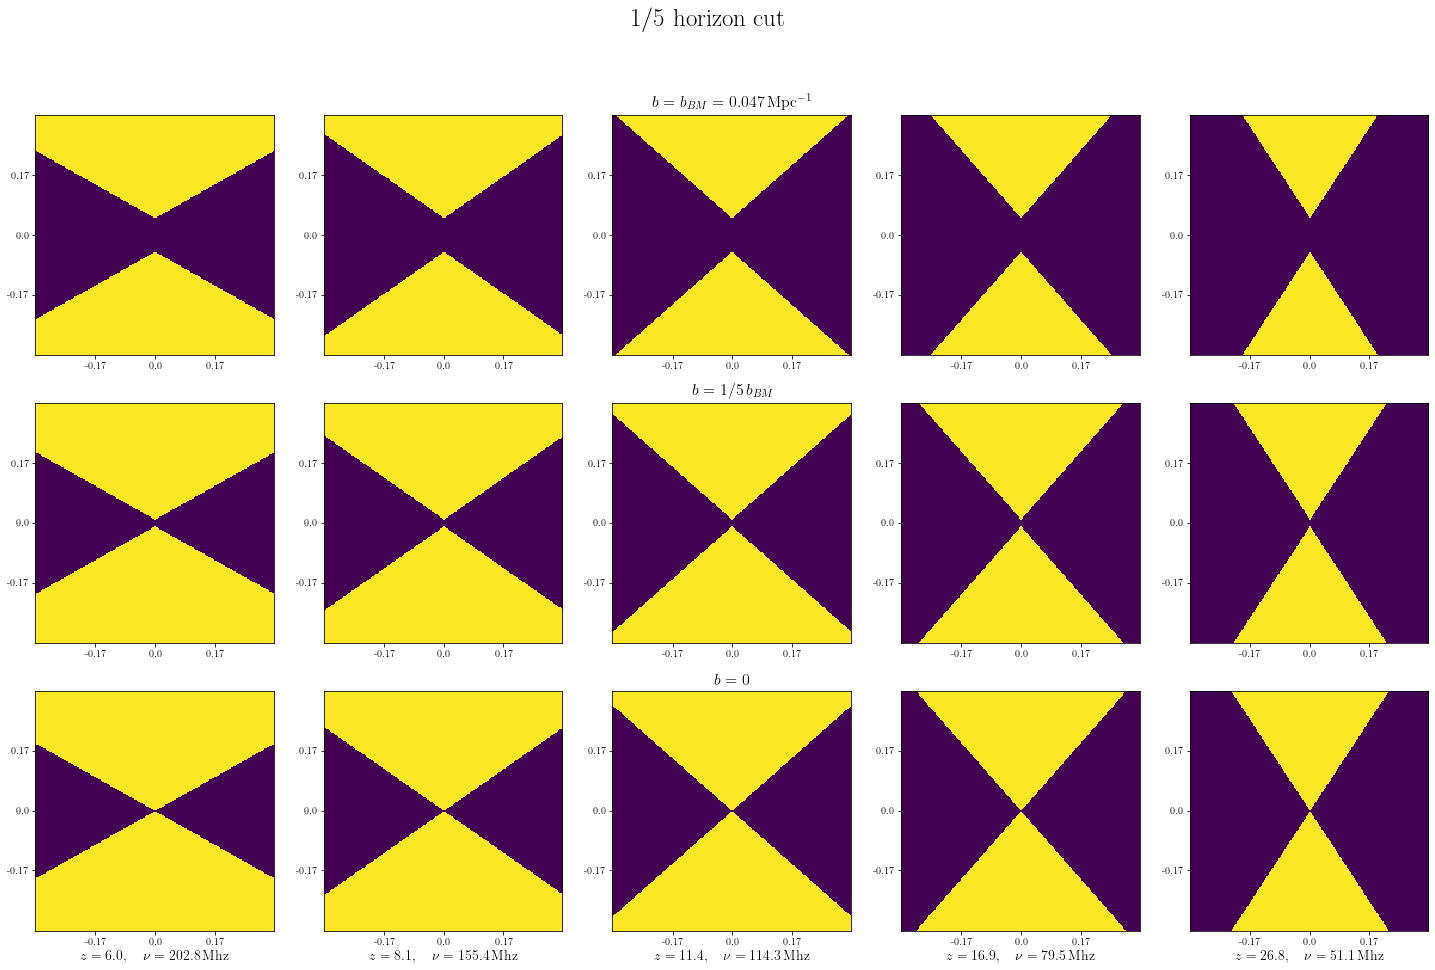

In [28]:
plt.figure(figsize=(25, 5 * 3))
for i in range(5):
    plt.subplot(3, 5, 1 + i)
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i*500] / inputs.wedge_correction) + BM_smoothing)
    w = cp.fft.fftshift(cp.logical_or(W < -1., W > 1.)[0]).get()
    plt.imshow(w.astype("float").T, origin='lower')
#     plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=14)
    plt.xticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.yticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    if i == 2:
        plt.title("$b = b_{BM} = %.3f \, \mathrm{Mpc^{-1}}$" % (BM_smoothing), fontsize=16)
for i in range(5):
    plt.subplot(3, 5, 6 + i)
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i*500] / inputs.wedge_correction) + BM_smoothing / 5)
    w = cp.fft.fftshift(cp.logical_or(W < -1., W > 1.)[0]).get()
    plt.imshow(w.astype("float").T, origin='lower')
#     plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=14)
    plt.xticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.yticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    if i == 2:
        plt.title("$b = 1/5 \, b_{BM}$", fontsize=16)
for i in range(5):
    plt.subplot(3, 5, 11 + i)
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i*500] / inputs.wedge_correction))
    w = cp.fft.fftshift(cp.logical_or(W < -1., W > 1.)[0]).get()
    plt.imshow(w.astype("float").T, origin='lower')
    plt.xticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.yticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=14)
    if i == 2:
        plt.title("$b = 0$", fontsize=16)
plt.suptitle("$1/5$ horizon cut", fontsize = 25)
plt.show()

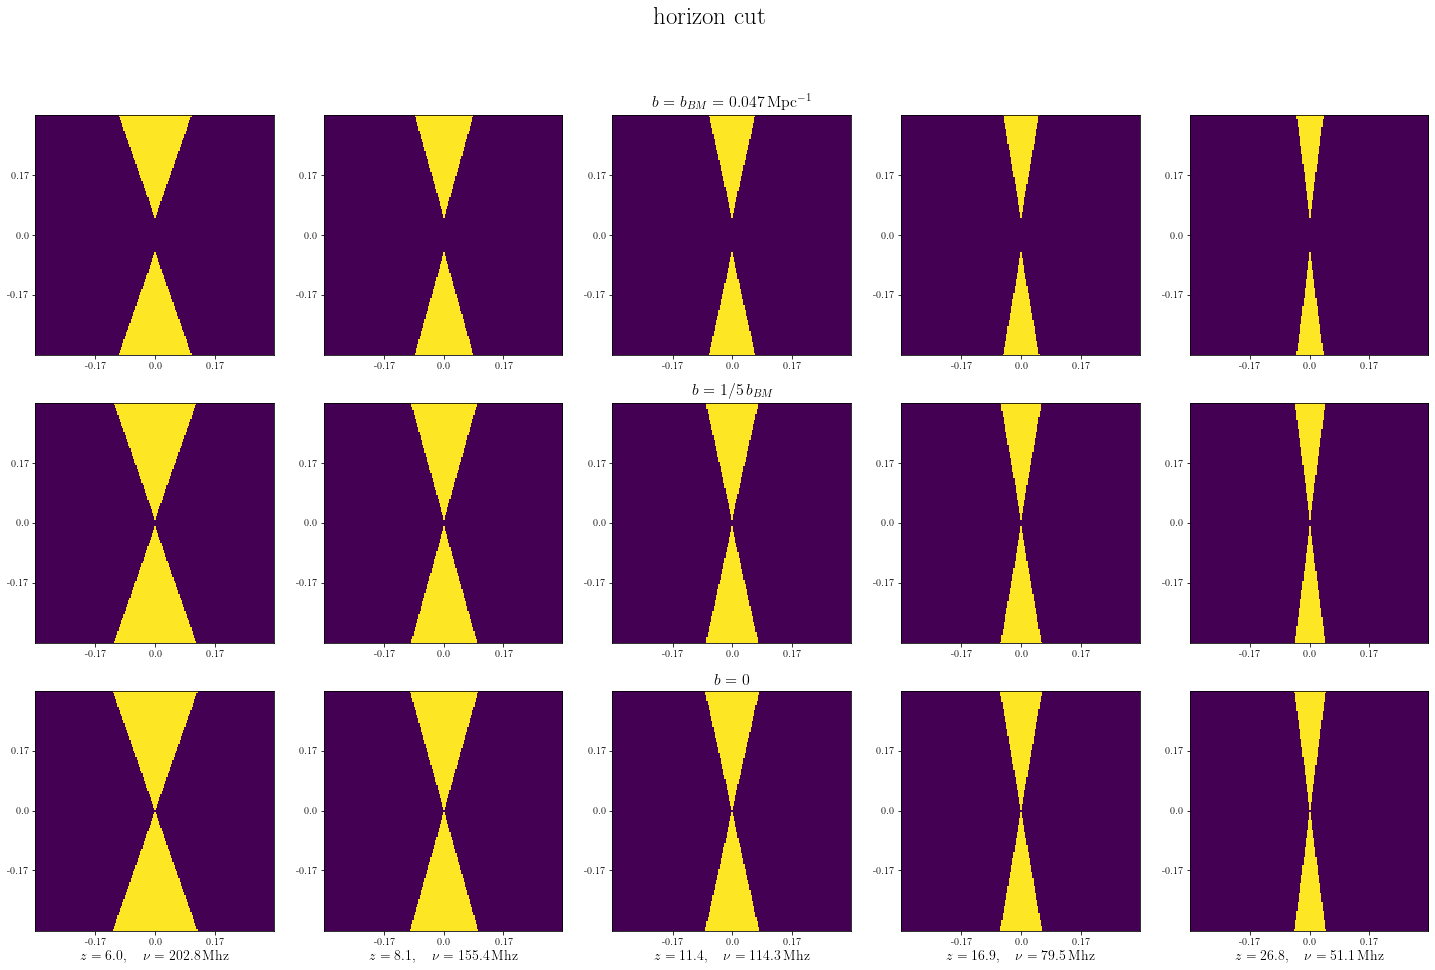

In [26]:
plt.figure(figsize=(25, 5 * 3))
for i in range(5):
    plt.subplot(3, 5, 1 + i)
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i*500]) + BM_smoothing)
    w = cp.fft.fftshift(cp.logical_or(W < -1., W > 1.)[0]).get()
    plt.imshow(w.astype("float").T, origin='lower')
#     plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=14)
    plt.xticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.yticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    if i == 2:
        plt.title("$b = b_{BM} = %.3f \, \mathrm{Mpc^{-1}}$" % (BM_smoothing), fontsize=16)
for i in range(5):
    plt.subplot(3, 5, 6 + i)
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i*500]) + BM_smoothing / 5)
    w = cp.fft.fftshift(cp.logical_or(W < -1., W > 1.)[0]).get()
    plt.imshow(w.astype("float").T, origin='lower')
#     plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=14)
    plt.xticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.yticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    if i == 2:
        plt.title("$b = 1/5 \, b_{BM}$", fontsize=16)
for i in range(5):
    plt.subplot(3, 5, 11 + i)
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (multiplicative_fact[i*500]))
    w = cp.fft.fftshift(cp.logical_or(W < -1., W > 1.)[0]).get()
    plt.imshow(w.astype("float").T, origin='lower')
    plt.xticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.yticks([50, 100, 150], np.round(cp.fft.fftshift(k0)[50::50].get(), decimals=2))
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=14)
    if i == 2:
        plt.title("$b = 0$", fontsize=16)
plt.suptitle("horizon cut", fontsize = 25)
plt.show()

In [ ]:
# a = np.zeros((200, 201))
# a[10, 190] = 1

for i in range(W.shape[0] // 250):
    plt.imshow(cp.real(cp.fft.fftshift(cp.fft.fftn(Box[..., i*250:i*250+chunk_length])[0])).get(), origin='lower')
    plt.imshow(cp.fft.fftshift(W[i*250, 0]).get().astype(float), origin = 'lower', alpha = 0.1)
#     plt.imshow(a, origin = 'lower')
#     plt.imshow(cp.real(cp.fft.fftshift(cp.fft.fftn(Box[..., i*250:i*250+inputs.chunk_length])))[0, ...].get(), origin= 'lower')
#     plt.scatter([50],[150])
    plt.colorbar()
    plt.show()

## $b = b_{BM}, \, k_{\|} = 1/5 \, k_{\|hc} $

In [ ]:
for walker in range(20, 21):
    Noise = noise(inputs.depth_mhz, inputs.seed_index, walker)
    # Noise = cp.asarray(Noise)

    Box = database.CombineBoxes(walker)
    Box = Filters.RemoveLargeZ(Box, database, Z=Zmax)
    Box[cp.isnan(Box)] = deltaTmin
    # cp.nan_to_num(Box, copy=False, nan=deltaTmin)
    cp.clip(Box, deltaTmin, deltaTmax, out=Box)
    Box -= averages[walker]
    Box = Box.astype(np.float32)
    plotting(Box)
#     result[walker, ...] = BoxCar3D_smart(manual_sliding(Box, Noise)).get()
    res = manual_sliding(Box, Noise)
    plotting(res)
    plotting(BoxCar3D_smart(res).get())

## $b = 1/5 \, b_{BM}, \, k_{\|} = 1/5 \, k_{\|hc} $

In [ ]:
for walker in range(20, 21):
    Noise = noise(inputs.depth_mhz, inputs.seed_index, walker)
    # Noise = cp.asarray(Noise)

    Box = database.CombineBoxes(walker)
    Box = Filters.RemoveLargeZ(Box, database, Z=Zmax)
    Box[cp.isnan(Box)] = deltaTmin
    # cp.nan_to_num(Box, copy=False, nan=deltaTmin)
    cp.clip(Box, deltaTmin, deltaTmax, out=Box)
    Box -= averages[walker]
    Box = Box.astype(np.float32)
    plotting(Box)
    result[walker, ...] = BoxCar3D_smart(manual_sliding(Box, Noise)).get()
    plotting(manual_sliding(Box, Noise))
    plotting(result[walker, ...])

## $b = 0, \, k_{\|} = 1/5 \, k_{\|hc} $

In [ ]:
for walker in range(20, 21):
    Noise = noise(inputs.depth_mhz, inputs.seed_index, walker)
    # Noise = cp.asarray(Noise)

    Box = database.CombineBoxes(walker)
    Box = Filters.RemoveLargeZ(Box, database, Z=Zmax)
    Box[cp.isnan(Box)] = deltaTmin
    # cp.nan_to_num(Box, copy=False, nan=deltaTmin)
    cp.clip(Box, deltaTmin, deltaTmax, out=Box)
    Box -= averages[walker]
    Box = Box.astype(np.float32)
    plotting(Box)
    result[walker, ...] = BoxCar3D_smart(manual_sliding(Box, Noise)).get()
    plotting(manual_sliding(Box, Noise))
    plotting(result[walker, ...])